In [ ]:

import torch
import torchvision
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,16)
torch.manual_seed(0)

In [ ]:
def show_tensor(image_tensor, num_images = 32, size = (3,64,64)):
    image_tensor = (image_tensor + 1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrows = 4)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()

In [ ]:
class MappingLayer(nn.Module):
    """
    Parameters:
        z_dim: dimensions of noise vector
        hidden_dim: hidden dimensions
        w_dim: the dimensions of intermediate noise vector
    """
    def __init__(self, z_dim = 512, hidden_dim = 128, w_dim = 512):
        super().__init__()
        self.mapping = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(), #conside LeakyReLU in future
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, w_dim)
        )

    def forward(self, noise):
        return self.mapping(noise)



class GenFeatureBase(nn.Module):
    """
    Parameters:
        z_dim: noise vector dimension but only segment of it
        hidden_dim: dimensions of hidden layer

    """
    def __init__(self, z_dim = 512, hidden_dim = 64,):
        super().__init__()
        self.z_dim = z_dim   
        self.genFeatureBlock = nn.Sequential(
            self.make_gen_feature_base(z_dim, hidden_dim * 2, 
                                        kernel_size = 4, stride = 1),  #input 512 x 1 x 1 output 128 x 4 x 4 
            self.make_gen_feature_base(hidden_dim * 2, hidden_dim ,
                                        kernel_size = 5, stride = 1), # input 128 x 4 x 4 output 64 x 8 x 8 
            self.make_gen_feature_base(hidden_dim , hidden_dim,
                                        kernel_size = 4, stride = 2), # input 64 x 8 x 8 output 64 x 18 x 18 
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = 3, stride = 1 ) #64 x 18 x 18 -> 64 x 16 x 16
        )
    def make_gen_feature_base(self, in_ch, op_ch, kernel_size, stride, final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, op_ch, kernel_size, stride),
                nn.InstanceNorm2d(op_ch, affine=True),
                nn.LeakyReLU(0.01, inplace = True), # hyperparameter
                )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, op_ch, kernel_size, stride),
                nn.LeakyReLU(0.01, inplace = True), # hyperparameter
            )

    def forward(self, noise):   
        #x = noise.view(len(noise), self.z_dim, 1, 1)
        x = noise
        x_prime = self.genFeatureBlock(x)
        #_x_prime = x_prime.view(x_prime.size()[0], -1)
        #print(x_prime.shape)
        return x_prime



class GenFeatureBlock(nn.Module):
    """
    Parameters:
        z_dim: noise vector dimension but only segment of it
        hidden_dim: dimensions of hidden layer

    """
    def __init__(self, z_dim = 128, hidden_dim = 64,):
        super().__init__()
        self.z_dim = z_dim   
        self.genFeatureBlock = nn.Sequential(
             self.make_gen_feature_layer(z_dim, hidden_dim * 2, 
                                        kernel_size = 4, stride = 1),  #input 128 x 1 x 1 output 128 x 4 x 4 
            self.make_gen_feature_layer(hidden_dim * 2, hidden_dim,
                                        kernel_size = 5, stride = 1), # input 128 x 4 x 4 output 64 x 8 x 8 
            self.make_gen_feature_layer(hidden_dim, hidden_dim,
                                        kernel_size = 4, stride = 2), # input 64 x 8 x 8 output 64 x 18 x 18 
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = 3, stride = 1 ) #64 x 18 x 18 -> 64 x 16 x 16
        )
    def make_gen_feature_layer(self, in_ch, op_ch, kernel_size, stride, final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, op_ch, kernel_size, stride),
                nn.InstanceNorm2d(op_ch, affine=True),
                nn.LeakyReLU(0.01, inplace = True), # hyperparameter
                )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, op_ch, kernel_size, stride),
                nn.LeakyReLU(0.01, inplace = True), # hyperparameter
            )

    def forward(self, noise):   
        #x = noise.view(len(noise), self.z_dim, 1, 1)
        x = noise
        x_prime = self.genFeatureBlock(x)
        #_x_prime = x_prime.view(x_prime.size()[0], -1)
        #print(x_prime.shape)
        return x_prime





class GeneratorHead(nn.Module):

    def __init__(self, z_dim = 320, hidden_dim = 32, im_ch = 3):
        super().__init__()
        self.z_dim = z_dim

        self.genHead = nn.Sequential(
            self.make_gen_head(z_dim, hidden_dim * 8, kernel_size = 5, stride = 1), # 64x16x16-> 256x20x20
            self.make_gen_head(hidden_dim * 8, hidden_dim * 8, kernel_size = 5, stride = 2),#2 for 128
            self.make_gen_head(hidden_dim * 8, hidden_dim * 4, kernel_size= 5 , stride = 2),#2 for 128
            self.make_gen_head(hidden_dim * 4, hidden_dim * 4, kernel_size = 5, stride = 1), #128x30x30 -> 128x35x35
            self.make_gen_head(hidden_dim * 4, hidden_dim * 2, kernel_size = 5, stride = 1), #128x35x35 -> 64x40x40
            self.make_gen_head(hidden_dim * 2, hidden_dim * 2, kernel_size = 5, stride = 1), #64x40x40 -> 64x45x45
            self.make_gen_head(hidden_dim * 2, hidden_dim * 2, kernel_size = 5, stride = 1), #64x40x40 -> 64x45x45
            self.make_gen_head(hidden_dim * 2, hidden_dim * 2, kernel_size = 5, stride = 1), #64x40x40 -> 64x45x45
            self.make_gen_head(hidden_dim * 2, hidden_dim * 2, kernel_size = 5, stride = 1), #64x40x40 -> 64x45x45
            self.make_gen_head(hidden_dim * 2, hidden_dim * 2, kernel_size = 4, stride = 1), # # for 128
            self.make_gen_head(hidden_dim * 2, hidden_dim * 2, kernel_size = 5, stride = 1), #64x40x40 -> 64x45x45
            self.make_gen_head(hidden_dim * 2, hidden_dim * 2, kernel_size = 5, stride = 1),
            self.make_gen_head(hidden_dim * 2, im_ch, kernel_size = 5, stride = 1, final_layer = True), #64x45x45 -> 32x50x50
            )

    def make_gen_head(self, in_ch, op_ch, kernel_size, stride, final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, op_ch, kernel_size, stride),
                nn.InstanceNorm2d(op_ch, affine=True),
                nn.LeakyReLU(0.01, inplace = True), # hyperparameter
                )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, op_ch, kernel_size, stride),
                nn.LeakyReLU(0.01, inplace = True)   ## change it here
            )

    def forward(self, feature_tensor):
        return self.genHead(feature_tensor)




class Generator(nn.Module):

    def __init__(self, z_dim = 512):
        super().__init__()
        self.z_dim = z_dim
        # divide noise vector here
        self.mappingLayer = MappingLayer()
        self.gen_base = GenFeatureBase()
        self.feature_layer_1 = GenFeatureBlock()
        self.feature_layer_2 = GenFeatureBlock()
        self.feature_layer_3 = GenFeatureBlock()
        self.feature_layer_4 = GenFeatureBlock()
        self.gen_head = GeneratorHead()

    def forward(self, noise):
        noise = noise
        print(noise.shape)
        latent_noise = self.mappingLayer(noise)
        print(f'noise MP : {latent_noise.shape}')
        latent_noise = latent_noise.view(len(latent_noise), self.z_dim, 1, 1)
        print(f'noise view: {latent_noise.shape}')
        base_out = self.gen_base(latent_noise)
        print(f'base_out: {base_out.shape}')
        noise_split = torch.hsplit(latent_noise, 4)
        x1 = noise_split[0]
        print(f'x1: {x1.shape}')
        
        x2 = noise_split[1]
        x3 = noise_split[2]
        x4 = noise_split[3]
        
        print(f'x1: {x1.shape}')
        f1 = self.feature_layer_1(x1)
        f2 = self.feature_layer_2(x2)
        f3 = self.feature_layer_3(x3)
        f4 = self.feature_layer_4(x4)
        print(f'f1: {f1.shape}')
        f = torch.hstack((base_out, f1, f2, f3, f4))
        print(f' f: {f.shape}')
        f_head = self.gen_head(f)
        print(f'head: {f_head.shape}')

        return f_head

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim).to(device)

In [ ]:
f = get_noise(12, 512)
#f = torch.randn(12,320,16,16)
#f.shape
z = Generator()
out = z(f)
out.shape

torch.Size([12, 512])
noise MP : torch.Size([12, 512])
noise view: torch.Size([12, 512, 1, 1])
base_out: torch.Size([12, 64, 16, 16])
x1: torch.Size([12, 128, 1, 1])
x1: torch.Size([12, 128, 1, 1])
f1: torch.Size([12, 64, 16, 16])
 f: torch.Size([12, 320, 16, 16])
head: torch.Size([12, 3, 128, 128])


torch.Size([12, 3, 128, 128])

In [ ]:
!pip install torch-summary
from torchsummary import summary

In [ ]:
summary(z)

Layer (type:depth-idx)                        Param #
├─MappingLayer: 1-1                           --
|    └─Sequential: 2-1                        --
|    |    └─Linear: 3-1                       65,664
|    |    └─BatchNorm1d: 3-2                  256
|    |    └─ReLU: 3-3                         --
|    |    └─Linear: 3-4                       33,024
|    |    └─BatchNorm1d: 3-5                  512
|    |    └─ReLU: 3-6                         --
|    |    └─Linear: 3-7                       131,584
|    |    └─BatchNorm1d: 3-8                  1,024
|    |    └─ReLU: 3-9                         --
|    |    └─Linear: 3-10                      262,656
├─GenFeatureBase: 1-2                         --
|    └─Sequential: 2-2                        --
|    |    └─Sequential: 3-11                  1,048,960
|    |    └─Sequential: 3-12                  204,992
|    |    └─Sequential: 3-13                  65,728
|    |    └─Conv2d: 3-14                      36,928
├─GenFeatureBlock: 1-

Layer (type:depth-idx)                        Param #
├─MappingLayer: 1-1                           --
|    └─Sequential: 2-1                        --
|    |    └─Linear: 3-1                       65,664
|    |    └─BatchNorm1d: 3-2                  256
|    |    └─ReLU: 3-3                         --
|    |    └─Linear: 3-4                       33,024
|    |    └─BatchNorm1d: 3-5                  512
|    |    └─ReLU: 3-6                         --
|    |    └─Linear: 3-7                       131,584
|    |    └─BatchNorm1d: 3-8                  1,024
|    |    └─ReLU: 3-9                         --
|    |    └─Linear: 3-10                      262,656
├─GenFeatureBase: 1-2                         --
|    └─Sequential: 2-2                        --
|    |    └─Sequential: 3-11                  1,048,960
|    |    └─Sequential: 3-12                  204,992
|    |    └─Sequential: 3-13                  65,728
|    |    └─Conv2d: 3-14                      36,928
├─GenFeatureBlock: 1-

In [ ]:
noise = get_noise(10, 512)
noise = noise.view(len(noise), 512, 1, 1)
print(noise.shape)
noise_2 = torch.hsplit(noise, 4)
print(len(noise_2))
print(noise_2[0].shape)
print(noise_2[1].shape)
print(noise_2[2].shape)
print(noise_2[3].shape)

torch.Size([10, 512, 1, 1])
4
torch.Size([10, 128, 1, 1])
torch.Size([10, 128, 1, 1])
torch.Size([10, 128, 1, 1])
torch.Size([10, 128, 1, 1])


In [ ]:
y = torch.randn(10, 256, 4, 4)
y = torch.hsplit(y, 4)
print(y[0].shape)

torch.Size([10, 64, 4, 4])


In [ ]:
v = torch.hstack((noise_2[0], noise_2[1], noise_2[2], noise_2[3]))
v.shape

torch.Size([10, 512, 1, 1])

In [ ]:
class CriticSpine(nn.Module):

    def __init__(self, im_ch = 3, hidden_dim = 16):
        super().__init__()
        self.spine = nn.Sequential(
            self.construct_spine(im_ch, hidden_dim),
            self.construct_spine(hidden_dim, hidden_dim * 2, stride = 2),
            self.construct_spine(hidden_dim * 2, hidden_dim * 2),
            self.construct_spine(hidden_dim * 2, hidden_dim *4, stride = 2),
            self.construct_spine(hidden_dim * 4, hidden_dim * 4),
            self.construct_spine(hidden_dim * 4, hidden_dim * 8,),
            self.construct_spine(hidden_dim * 8, hidden_dim * 8),
            self.construct_spine(hidden_dim * 8, hidden_dim * 16),
            )

    def construct_spine(self, in_ch, op_ch, kernel_size = 3, stride = 1, padding = 1, final_layer = False):
        return nn.Sequential(
            nn.Conv2d(in_ch, op_ch, kernel_size, stride, padding),
            nn.InstanceNorm2d(op_ch, affine=True),
            nn.LeakyReLU(0.01, inplace = True),
            )

    def forward(self, image):
        spine_pred = self.spine(image)
        #print(len(spine_pred))
        #print(spine_pred.shape)
        return spine_pred


class CriticHead(nn.Module):

    def __init__(self, in_dim = 64, hidden_dim = 16):
        super().__init__()
        self.criticHead = nn.Sequential(
            self.make_feature_head(in_dim, hidden_dim * 16),
            self.make_feature_head(hidden_dim * 16, hidden_dim * 8, stride = 2),
            self.make_feature_head(hidden_dim * 8, hidden_dim * 4),
            self.make_feature_head(hidden_dim * 4, hidden_dim * 2),
            )

    def make_feature_head(self, in_ch, op_ch, kernel_size = 3, stride = 1, padding = 1):
        return nn.Sequential(
            nn.Conv2d(in_ch, op_ch, kernel_size, stride, padding),
            nn.InstanceNorm2d(op_ch, affine=True),
            nn.LeakyReLU(0.01, inplace = True)
        )

    def forward(self, feature_tensor):
        x = self.criticHead(feature_tensor)
        #print(x.shape)
        return x


class CriticSkullCap(nn.Module):
    
    def __init__(self, z_dim = 128, hidden_dim = 128):
        super().__init__()
        self.skullcap = nn.Sequential(
            self.make_skull_cap(z_dim , hidden_dim, stride = 2),
            self.make_skull_cap(hidden_dim , hidden_dim * 2, stride = 2),
            self.make_skull_cap(hidden_dim *2  , 1, final_layer = True),
        )

    def make_skull_cap(self, in_ch, op_ch, kernel_size = 3, stride = 1, padding = 1, final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_ch, op_ch, kernel_size, stride, padding),
                nn.InstanceNorm2d(op_ch, affine=True),
                nn.LeakyReLU(0.01, inplace = True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_ch, op_ch, kernel_size, stride, padding),
                nn.LeakyReLU(0.01, inplace = True),
            )

    def forward(self, concat_tensor):
        x = self.skullcap(concat_tensor)
        #print(x.shape)
        return x


class Critic(nn.Module):

    def __init__(self, im_ch = 3):
        super().__init__()
        self.im_ch = im_ch
        self.spine = CriticSpine()
        self.head_1 = CriticHead()
        self.head_2 = CriticHead()
        self.head_3 = CriticHead()
        self.head_4 = CriticHead()
        self.skullcap = CriticSkullCap()

    def forward(self, image):
        x = self.spine(image)
        print(f'x: {x.shape}')
        x = torch.hsplit(x, 4)
        print(x[0].shape)
        h1 = self.head_1(x[0])
        h2 = self.head_2(x[1])
        h3 = self.head_3(x[2])
        h4 = self.head_4(x[3])

        print(f'h1: {h1.shape}')

        head = torch.hstack((h1, h2, h3, h4))
        print(f'head: {head.shape}')

        crit_pred = self.skullcap(head)
        print(f'cp: {crit_pred.shape}')
        z = crit_pred.view(len(crit_pred), -1)
        #print(f'z: {z.shape}')

        return crit_pred






In [ ]:
f = torch.randn(1, 3, 128, 128)
model = Critic()
out = model(f)
out.shape

x: torch.Size([1, 256, 32, 32])
torch.Size([1, 64, 32, 32])
h1: torch.Size([1, 32, 16, 16])
head: torch.Size([1, 128, 16, 16])
cp: torch.Size([1, 1, 4, 4])


torch.Size([1, 1, 4, 4])

In [ ]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
import os
import pandas as pd

In [ ]:
class CarsDataset(Dataset):
    def __init__(self, csv_file, root_dir,
                 transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = read_image(img_path, mode = ImageReadMode.RGB)
        label = torch.tensor(int(self.annotations.iloc[idx, 1]))
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
dataset = CarsDataset(csv_file='/content/TrainLabel.csv',
            root_dir='/content/drive/MyDrive/StanfordCars/archive/cars_train/cars_train', 
            transform = transform)

In [ ]:
print(len(dataset))
type(dataset)

8144


__main__.CarsDataset

In [ ]:
import torch.utils.data as data_utils
indices = torch.arange(32)
dataset_1k = data_utils.random_split(dataset, [1280,6864], generator=torch.Generator().manual_seed(42))
print(len(dataset_1k))
type(dataset_1k)
dataset_1280 = dataset_1k[0]
len(dataset_1280)

2


1280

In [ ]:
help(torch.utils.data.random_split)

Help on function random_split in module torch.utils.data.dataset:

random_split(dataset: torch.utils.data.dataset.Dataset[~T], lengths: Sequence[int], generator: Union[torch._C.Generator, NoneType] = <torch._C.Generator object at 0x7f3ea6bdb330>) -> List[torch.utils.data.dataset.Subset[~T]]
    Randomly split a dataset into non-overlapping new datasets of given lengths.
    Optionally fix the generator for reproducible results, e.g.:
    
    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    
    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths of splits to be produced
        generator (Generator): Generator used for the random permutation.



In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset_1280, 
                              batch_size=32,
                              shuffle = True)

train_images, _ = next(iter(train_dataloader))

40
torch.Size([32, 3, 64, 64])


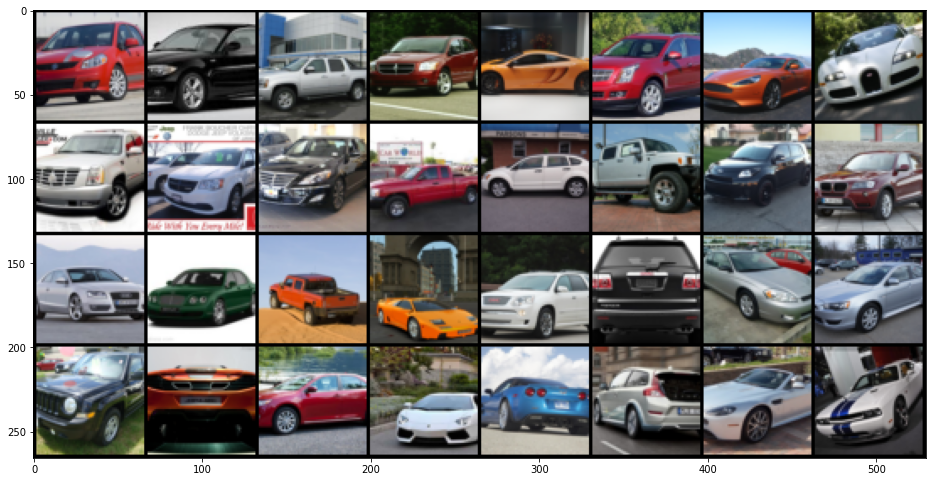

In [ ]:
print(len(train_dataloader))
train_images, _ = next(iter(train_dataloader))
print(train_images.shape)
show_tensor(train_images)

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)

    
    mixed_scores = crit(mixed_images)
    
    
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [ ]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)
    
    penalty = torch.mean((gradient_norm-1)**2)
    return penalty

In [ ]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1*torch.mean(crit_fake_pred)
    return gen_loss

In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda*gp
    return crit_loss

In [ ]:
n_epochs = 2
z_dim = 512
display_step = 50
batch_size = 32
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 2
device = 'cuda' 

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(train_dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor(fake)
            show_tensor(real)
            torch.save(gen.state_dict(), 'gen_weights.pth')
            torch.save(crit.state_dict(), 'crit_weights.pth')
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

  0%|          | 0/255 [00:00<?, ?it/s]

KeyboardInterrupt: ignored